In [1]:
#!/usr/bin/env python

import logging
import os

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import (
    get_era5_reanalysis_data,
    get_earthenv_auxiliary_data,
    get_gldas_land_mask,
)

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm


In [2]:
# Training/data config
#data_range = ("2010-01-01", "2019-12-31")
#train_range = ("2010-01-01", "2018-12-31")
#val_range = ("2019-01-01", "2019-12-31")
data_range = ("2010-01-01", "2010-01-30")
train_range = ("2010-01-01", "2010-01-20")
val_range = ("2010-01-21", "2010-01-30")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
verbose_download = True




era5_raw_ds = get_era5_reanalysis_data(
    era5_var_IDs,
    extent,
    date_range=data_range,
    cache=True,
    cache_dir=cache_dir,
    verbose=verbose_download,
    num_processes=8,
)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(
    lowres_auxiliary_var_IDs,
    extent,
    "100KM",
    cache=True,
    cache_dir=cache_dir,
    verbose=verbose_download,
)
land_mask_raw_ds = get_gldas_land_mask(
    extent, cache=True, cache_dir=cache_dir, verbose=verbose_download
)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor(
    [lowres_aux_raw_ds, land_mask_raw_ds], method="min_max"
)

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


0.01 GB loaded in 0.37 s


In [3]:
era5_raw_ds

<xarray.Dataset>
Dimensions:         (time: 30, lat: 241, lon: 401)
Coordinates:
  * lat             (lat) float32 75.0 74.75 74.5 74.25 ... 15.5 15.25 15.0
  * lon             (lon) float32 -160.0 -159.8 -159.5 ... -60.5 -60.25 -60.0
  * time            (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-01-30
Data variables:
    2m_temperature  (time, lat, lon) float32 251.1 251.1 251.2 ... 298.8 298.8

In [4]:
dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]




set_gpu_default_device()


# ## Initialise TaskLoader and ConvNP model



task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader2 = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
task_loader2.load_dask()
print(task_loader)


TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [5]:
# Set up model
model_patched = ConvNP(data_processor, task_loader, unet_channels=(32, 32, 32, 32, 32))
model = ConvNP(data_processor, task_loader2, unet_channels=(32, 32, 32, 32, 32))

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.0012499999720603228, 0.0012499999720603228, 0.00416666641831398]
decoder_scale inferred from TaskLoader: 0.0025
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.0012499999720603228, 0.0012499999720603228, 0.00416666641831398]
decoder_scale inferred from TaskLoader: 0.0025


In [6]:
patch_size = (0.2, 0.2)
stride = (0.1, 0.1)

# ## Define how Tasks are generated
def gen_training_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        tasks_per_date = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling="all",
            patch_strategy="sliding",
            patch_size=patch_size,
            stride=stride,
        )
        tasks.extend(tasks_per_date)
    return tasks

def gen_non_patched_training_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        task = task_loader2(date, 
                           context_sampling=["all", "all", "all"],
                           target_sampling="all"
                           )
        tasks.append(task)
    return tasks

def gen_validation_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        tasks_per_date = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling="all",
            patch_strategy="sliding",
            patch_size=patch_size,
            stride=stride
        )
        tasks.extend(tasks_per_date)
    return tasks

def gen_non_patched_validation_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        tasks_per_date = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling="all",
        )
        tasks.append(tasks_per_date)
    return tasks


# ## Generate validation tasks for testing generalisation
val_dates_patched = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
val_tasks_patched = gen_validation_tasks(val_dates_patched)

# ## Training with the Trainer class
def compute_val_rmse_patched(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))




100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


In [7]:
num_epochs = 2
losses_patched = []
val_rmses_patched = []

# # Train Patched model
val_rmse_best = np.inf
trainer_patched = Trainer(model_patched, lr=5e-5)
for epoch in tqdm(range(num_epochs)):
    train_tasks_patched = gen_training_tasks(pd.date_range(train_range[0], train_range[1])[::date_subsample_factor], progress=False)
    batch_losses_patched = trainer_patched(train_tasks_patched)
    losses_patched.append(np.mean(batch_losses_patched))
    val_rmses_patched.append(compute_val_rmse_patched(model_patched, val_tasks_patched))
    if val_rmses_patched[-1] < val_rmse_best:
        val_rmse_best = val_rmses_patched[-1]
        model_patched.save(deepsensor_folder)

100%|██████████| 2/2 [00:47<00:00, 23.76s/it]


In [8]:
num_epochs = 2
losses = []
val_rmses = []

def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader2.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

# ## Generate validation tasks for testing generalisation
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
val_tasks = gen_non_patched_training_tasks(val_dates)

# # Train non-patched model
val_rmse_best = np.inf
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(num_epochs)):
    train_tasks = gen_non_patched_validation_tasks(pd.date_range(train_range[0], train_range[1])[::date_subsample_factor], progress=False)
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model, val_tasks))
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
    model.save(deepsensor_folder)


  0%|          | 0/2 [00:00<?, ?it/s]100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


In [9]:
# prediction with patches ON-GRID, select one data from the validation tasks
# generate patchwise tasks for a specific date
# pick a random date as datetime64[ns]

dates = [np.datetime64("2010-01-25")]
eval_task_patched = gen_validation_tasks(dates, progress=False)
eval_task = gen_non_patched_training_tasks(dates, progress=False)

In [10]:
for task in eval_task_patched:
    x1_patch_coords = task['bbox'][0:2]
    x2_patch_coords = task['bbox'][2:]
    x1_index = [np.argmin(np.abs(era5_ds.coords['x1'].values - target_x1)) for target_x1 in x1_patch_coords] 
    x2_index = [np.argmin(np.abs(era5_ds.coords['x2'].values - target_x2)) for target_x2 in x2_patch_coords] 
    print('bbox', task['bbox'])
    print('x1 and x2 index', x1_index, x2_index)
    print('task size', len(task['X_c'][0][0][0]), len(task['X_c'][0][1][0]))
    
    
    

bbox [0.4000000238418579, 0.6000000238418579, 0.0, 0.2]
x1 and x2 index [80, 0] [0, 80]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.1, 0.30000000000000004]
x1 and x2 index [80, 0] [40, 120]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.2, 0.4]
x1 and x2 index [80, 0] [80, 160]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.30000000000000004, 0.5]
x1 and x2 index [80, 0] [120, 200]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.4, 0.6000000000000001]
x1 and x2 index [80, 0] [160, 240]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.5, 0.7]
x1 and x2 index [80, 0] [200, 280]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.6000000000000001, 0.8]
x1 and x2 index [80, 0] [240, 320]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.7000000000000001, 0.9000000000000001]
x1 and x2 index [80, 0] [280, 360]
task size 80 81
bbox [0.4000000238418579, 0.6000000238418579, 0.8, 1.0]
x

In [11]:


pred_patch = model_patched.predict_patch(eval_task_patched, data_processor=data_processor, X_t=era5_raw_ds, resolution_factor=2)
pred = model.predict(eval_task, X_t=era5_raw_ds)
#pred_temp = model_patched.predict(eval_task, X_t=era5_raw_ds)
#fig = deepsensor.plot.prediction(pred_patch, dates[0], data_processor, task_loader, eval_task[0], crs=ccrs.PlateCarree())
#fig = deepsensor.plot.prediction(pred_temp, dates[0], crs=ccrs.PlateCarree())
#fig.savefig(os.path.join(deepsensor_folder, "patchwise_prediction.png"))


print(0)

height and width of patch 80 81
patch location 0 79 0 80
Original patch overlap 20 20 20 20
borders 0 21 0 21
clipped patch extent 0 59 0 60
clipped patch location 0 58 0 59
height and width of patch 80 81
patch location 0 79 40 120
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 60 99
height and width of patch 80 81
patch location 0 79 80 160
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 100 139
height and width of patch 80 81
patch location 0 79 120 200
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 140 179
height and width of patch 80 81
patch location 0 79 160 240
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 180 219
height and width of patch 80 81
patch location 0 79 200 280
Original patch overlap 20 20 20 20
borders

In [12]:
pred_patch = model_patched.predict_patch(eval_task_patched, data_processor=data_processor, X_t=era5_raw_ds, resolution_factor=2)
print(np.shape(pred_patch[0]['mean'][0]))

height and width of patch 80 81
patch location 0 79 0 80
Original patch overlap 20 20 20 20
borders 0 21 0 21
clipped patch extent 0 59 0 60
clipped patch location 0 58 0 59
height and width of patch 80 81
patch location 0 79 40 120
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 60 99
height and width of patch 80 81
patch location 0 79 80 160
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 100 139
height and width of patch 80 81
patch location 0 79 120 200
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 140 179
height and width of patch 80 81
patch location 0 79 160 240
Original patch overlap 20 20 20 20
borders 0 21 20 21
clipped patch extent 0 59 20 60
clipped patch location 0 58 180 219
height and width of patch 80 81
patch location 0 79 200 280
Original patch overlap 20 20 20 20
borders

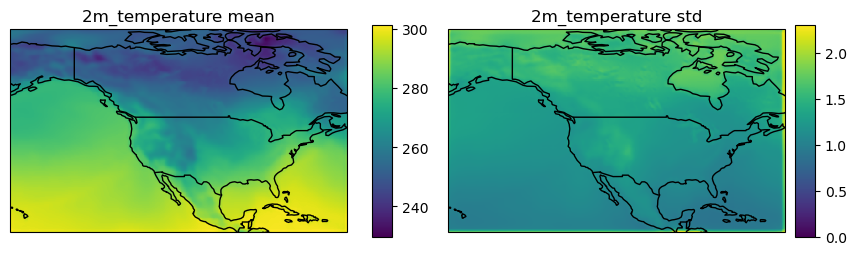

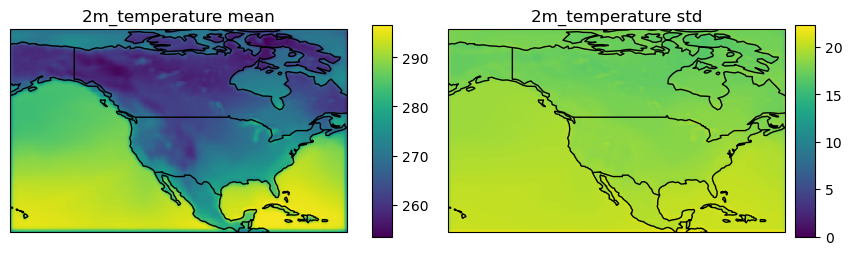

In [13]:
fig = deepsensor.plot.prediction(pred_patch, dates[0], data_processor, task_loader, eval_task[0], crs=ccrs.PlateCarree())
fig = deepsensor.plot.prediction(pred, dates[0], crs=ccrs.PlateCarree())


In [14]:
p_patch = pred_patch[0]['mean'][0]
p_patch_trimmed = p_patch.isel(lon=slice(0, 401))



In [15]:
print(np.shape(p_patch))

(237, 401)


(241, 401)


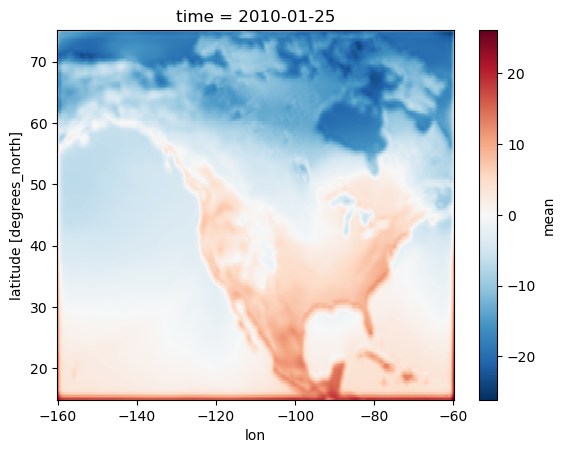

In [16]:
p_whole =pred[0]['mean'][0]
print(np.shape(p_whole))
diff = p_patch-p_whole
diff.plot()
plt.show()
#pred_whole_patched_training = pred_temp[0]['mean'][0]

In [17]:
from rasterio.plot import show 

p0_drop_dim =  np.concatenate((p_patch[:, 0:150], p_patch[:, 151:251], p_patch[:, 252:]), axis = 1)
#p0_drop_dim = np.concatenate((p_patch[:, 0:70], p_patch[:, 71:131], p_patch[:, 132:193], p_patch[:, 194:254], p_patch[:, 255:315], p_patch[:, 316:375], p_patch[:, 376:]), axis = 1)
#p0_drop_dim = np.concatenate((p_patch[:, 0:70], p_patch[:, 71:131], p_patch[:, 132:193], p_patch[:, 194:254], p_patch[:, 255:315], p_patch[:, 316:375], p_patch[:, 376:]), axis = 1)

diff = np.array(p_patch_trimmed) - np.array(p_whole)
result = xr.DataArray(diff, coords=p_whole.coords, dims=p_whole.dims)

# Compute the absolute values of the column sums
abs_result = np.abs(diff)

# Perform row-wise sum
col_sums = np.sum(abs_result, axis=0)

# Find the first column index where the absolute value is greater than 1
index = np.argmax(col_sums > 1)

print(index)

result.plot()
plt.show()

diff_patched_training = np.array(pred_whole_patched_training)-np.array(p0_drop_dim)
result_diff_patched_training = xr.DataArray(diff_patched_training, coords=p_whole.coords, dims=p_whole.dims)
result_diff_patched_training.plot()
plt.show()
#diff = np.array(p_patch[:, :401]) - np.array(p_whole)
#show(diff)
#print(np.max(diff))
# Create a new DataArray from the result, using coordinates from one of the original DataArrays
#p0_drop_dim_xr = xr.DataArray(p0_drop_dim, coords=p_whole.coords, dims=p_whole.dims)



ValueError: operands could not be broadcast together with shapes (237,401) (241,401) 

<function matplotlib.pyplot.show(close=None, block=None)>

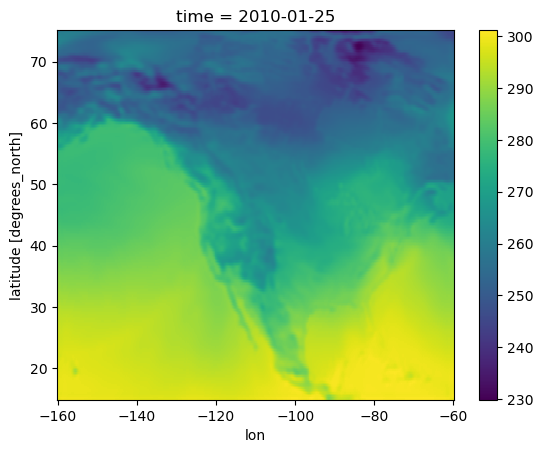

In [ ]:
p0_drop_dim_xr.plot()
plt.show

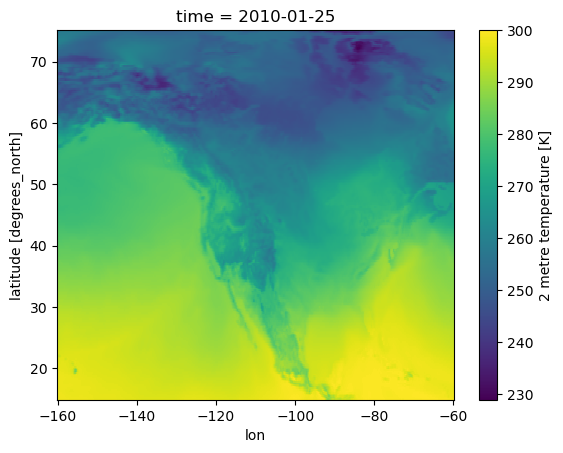

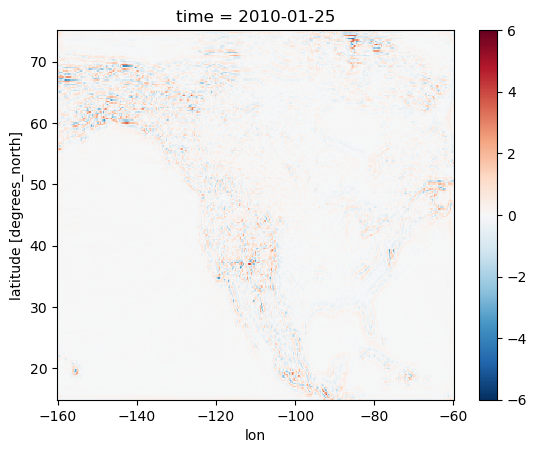

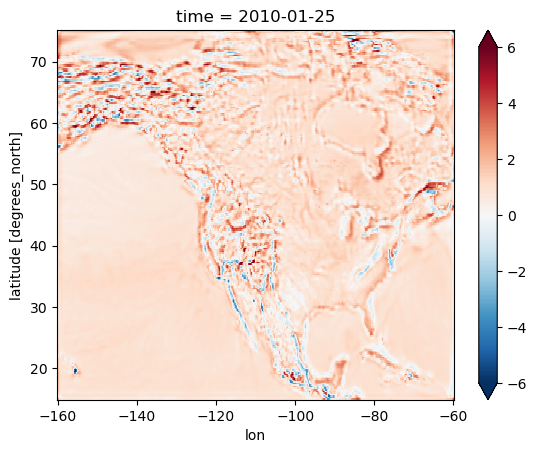

In [ ]:
era5_temp_validation = era5_raw_ds.sel(time = dates)
temp_validation = era5_temp_validation['2m_temperature']
temp_validation.plot()
plt.show()

diff_patches= np.array(temp_validation[0, :, :])-np.array(p0_drop_dim)
diff_patches_xr = xr.DataArray(diff_patches, coords=p_whole.coords, dims=p_whole.dims)
diff_patches_xr.plot(vmin = -6, vmax = 6, cmap = 'RdBu_r')
#diff_patches_xr.plot()
plt.show()

diff_no_patches= temp_validation-p_whole
diff_no_patches.plot(vmin = -6, vmax = 6, cmap = 'RdBu_r')
#diff_no_patches.plot()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_patched)
axes[1].plot(val_rmses_patched)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss when patching")
_ = axes[1].set_title("Validation RMSE when patching")

NameError: name 'test_task' is not defined